# Preprocessing Probe and Link Data

We import pandas to load and modify the csv files. Furthermore, we use seaborn to make some visualization of some statistics about the data. Finally, the utm package helps us to convert latitude and longitude into UTM coordinates. This makes it esasier to calculate distances between two given points.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from shapely.ops import nearest_points
from shapely import wkt
from shapely.geometry import LineString, Point

import math
import utm
import time
import geopandas

## 1. Probe Data
### 1.1 Basic Analysis

In [4]:
names = ["sampleID", "dateTime", "sourceCode", "latitude", "longitude", "altitude", "speed", "heading"]
data_probes = pd.read_csv("./data/ProbePoints.csv", header=None, names=names)
data_probes.index.name = 'probeID'
data_probes.head(10)

,sampleID,dateTime,sourceCode,latitude,longitude,altitude,speed,heading
probeID,,,,,,,,
0,3496,6/12/2009 6:12:49 AM,13,51.496868,9.386022,200,23,339
1,3496,6/12/2009 6:12:54 AM,13,51.496682,9.386157,200,10,129
2,3496,6/12/2009 6:12:59 AM,13,51.496705,9.386422,201,21,60
3,3496,6/12/2009 6:13:04 AM,13,51.496749,9.386840,201,0,360
4,3496,6/12/2009 6:13:09 AM,13,51.496864,9.387294,199,0,360
5,3496,6/12/2009 6:13:15 AM,13,51.496930,9.387716,198,5,89
6,3496,6/12/2009 6:13:20 AM,13,51.496957,9.387794,198,1,288
7,3496,6/12/2009 6:13:25 AM,13,51.496952,9.387805,197,0,310
8,3496,6/12/2009 6:13:30 AM,13,51.496949,9.387818,196,0,274


As we can see, there are more than 3 million probe data points! So we defitnitely need to find an efficient approach for matching all these points to the given map link elements. In addition, we can see that these 3 million points have been generated by 75000 different rides.

In [5]:
data_probes.info()
print("Unique probes",len(data_probes.sampleID.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3375745 entries, 0 to 3375744
Data columns (total 8 columns):
sampleID      int64
dateTime      object
sourceCode    int64
latitude      float64
longitude     float64
altitude      int64
speed         int64
heading       int64
dtypes: float64(2), int64(5), object(1)
memory usage: 206.0+ MB
Unique probes 75840


### 1.2 Means and Counts

Create mean and count statistics of the available probes. We can see that most of the samples have 30 - 40 or 60 different probe points. As expected, there is no clear pattern in the counts for the latitude, longitude and altitude for the probe data points. The only thing that we can see is that there are some areas that have higher traffic. Probably because there is a city or a highway! Additionally, all samples have the same source which means that we can drop the source column since it's not giving any information.

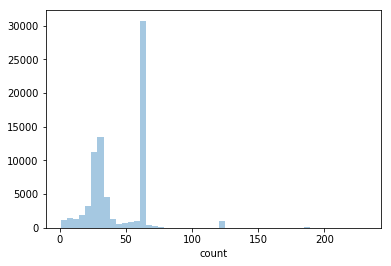

In [6]:
mean_per_probe = data_probes.groupby(['sampleID']).mean()
count_per_probe = data_probes.groupby(['sampleID']).count()[["sourceCode"]]
count_per_probe = count_per_probe.rename(index=str, columns={"sampleID": "sampleID", "sourceCode": "count"})

points_per_sample = pd.Series(count_per_probe["count"])
ax = sns.distplot(points_per_sample, kde = False)

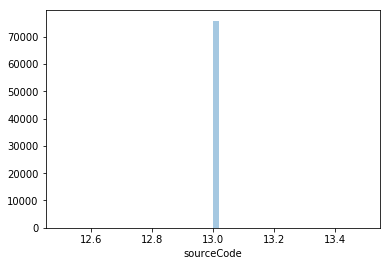

In [7]:
x = pd.Series(mean_per_probe["sourceCode"])
ax = sns.distplot(x,kde = False)

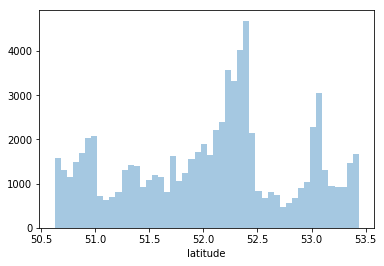

In [8]:
x = pd.Series(mean_per_probe["latitude"])
ax = sns.distplot(x,kde = False)

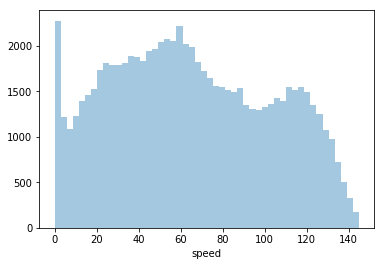

In [9]:
x = pd.Series(mean_per_probe["speed"])
ax = sns.distplot(x,kde = False)

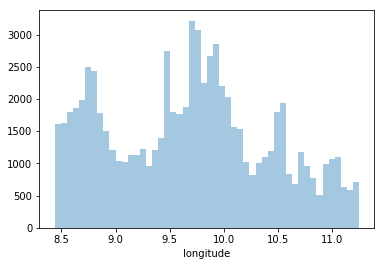

In [17]:
x = pd.Series(mean_per_probe["longitude"])
ax = sns.distplot(x,kde = False)

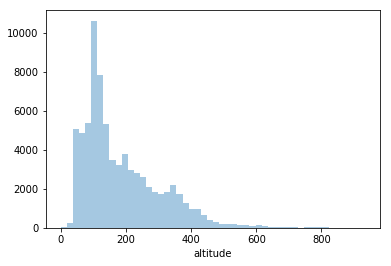

In [18]:
d = mean_per_probe[(mean_per_probe['altitude'] >= 0) & (mean_per_probe['altitude'] <= 1000)]

x = pd.Series(d["altitude"])
ax = sns.distplot(x,kde = False)

Finnaly, I tried to convert the latitude and the longitude of a given probe point to UTM coordinates. This was fairly easy and works!

In [19]:
latitude = mean_per_probe.iloc[0,1]
longitude = mean_per_probe.iloc[0,2]
print("LatLong    = lat:",latitude,"long:",longitude)
print("UTM coords =", utm.from_latlon(latitude, longitude))

LatLong    = lat: 51.49695099730576 long: 9.387096830510668
UTM coords = (526871.1989215489, 5705161.114264976, 32, 'U')


### 1.3 Cleaning and Converting

To clean the data for the probe points we will do the following things:
- Drop column "sourceCode"
- Drop column "dateTime"
- Convert "latitude" and "longitude" to UTM coordinates

In [20]:
data_probes.head()

,sampleID,dateTime,sourceCode,latitude,longitude,altitude,speed,heading
probeID,,,,,,,,
0,3496,6/12/2009 6:12:49 AM,13,51.496868,9.386022,200,23,339
1,3496,6/12/2009 6:12:54 AM,13,51.496682,9.386157,200,10,129
2,3496,6/12/2009 6:12:59 AM,13,51.496705,9.386422,201,21,60
3,3496,6/12/2009 6:13:04 AM,13,51.496749,9.386840,201,0,360
4,3496,6/12/2009 6:13:09 AM,13,51.496864,9.387294,199,0,360


In [21]:
def calculate_easting(row):
    utm_coords = utm.from_latlon(row["latitude"],row["longitude"])
    return utm_coords[0]

def calculate_northing(row):
    utm_coords = utm.from_latlon(row["latitude"],row["longitude"])
    return utm_coords[1]

def calculate_point_wkt(row):
    wkt = "POINT ( " + str(row["longitude"]) + " " + str(row["latitude"]) + ")"
    return wkt

data_probes["shape"] = data_probes.apply(calculate_point_wkt, axis=1)
data_probes["easting"] = data_probes.apply(calculate_easting, axis=1)
data_probes["northing"] = data_probes.apply(calculate_northing, axis=1)
data_probes["zoneNumber"] = 32
data_probes["zoneLetter"] = "U"
data_probes['shape'] = data_probes['shape'].apply(wkt.loads)
data_probes = geopandas.GeoDataFrame(data_probes, geometry='shape')
data_probes = data_probes.drop(["sourceCode"],axis=1)
data_probes = data_probes.drop(["dateTime"],axis=1)
data_probes.to_csv("./data/ProbePointsCleaned.csv")

In [22]:
data_probes.head()

,sampleID,latitude,longitude,altitude,speed,heading,shape,easting,northing,zoneNumber,zoneLetter
probeID,,,,,,,,,,,
0,3496,51.496868,9.386022,200,23,339,POINT (9.38602223061025 51.496868217364),526796.651941,5.705152e+06,32,U
1,3496,51.496682,9.386157,200,10,129,POINT (9.38615726307034 51.49668222293261),526806.134609,5.705131e+06,32,U
2,3496,51.496705,9.386422,201,21,60,POINT (9.386422298848631 51.4967048540711),526824.519427,5.705133e+06,32,U
3,3496,51.496749,9.386840,201,0,360,POINT (9.38683996908367 51.4967492781579),526853.486901,5.705139e+06,32,U
4,3496,51.496864,9.387294,199,0,360,POINT (9.387294016778471 51.4968639425933),526884.938219,5.705152e+06,32,U


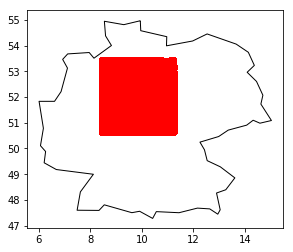

In [23]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.name == 'Germany'].plot(color='white', edgecolor='black')

data_probes.plot(ax=ax, color='red')

plt.show()

## 2. Link Data
### 2.1 Basic Analysis

The next step was analyzing the link data. The most important column for us will probably be the shapeInfo and the refNode columns. However, it is quite unclear what the refNode is. Since we will need to calculate the distance to it we might need to ask the TA for this. Apart from that there are 200k link elements consisting of a start and and end location. It seems that some of the links also have an elevation while others do not have any elevation information.

In [103]:
names = ["linkPVID","refNodeID","nrefNodeID","length","functionalClass","directionOfTravel","speedCategory","fromRefSpeedLimit","toRefSpeedLimit","fromRefNumLanes","toRefNumLanes","multiDigitized","urban","timeZone","shapeInfo","curvatureInfo","slopeInfo"]
data_links = pd.read_csv("./data/LinkData.csv", header=None, names=names)
data_links.head(10)

,linkPVID,refNodeID,nrefNodeID,length,functionalClass,directionOfTravel,speedCategory,fromRefSpeedLimit,toRefSpeedLimit,fromRefNumLanes,toRefNumLanes,multiDigitized,urban,timeZone,shapeInfo,curvatureInfo,slopeInfo
0,62007637,162844982,162809070,335.04,5,B,7,30,30,0,0,F,T,0.0,51.4965800/9.3862299/|51.4994700/9.3848799/,NaN,NaN
1,567329767,162844982,162981512,134.56,5,B,7,0,0,0,0,F,T,0.0,51.4965800/9.3862299/|51.4966899/9.3867100/|51...,NaN,NaN
2,62007648,162877732,162844982,97.01,5,B,7,30,30,0,0,F,T,0.0,51.4962899/9.3849100/|51.4965800/9.3862299/,NaN,NaN
3,78670326,162877732,163152693,314.84,5,B,7,30,30,0,0,F,T,0.0,51.4962899/9.3849100/|51.4990000/9.3836099/,NaN,NaN
4,51881672,174713859,174587951,110.17,3,B,6,50,50,2,2,F,T,0.0,53.0643099/8.7903400/45.79|53.0650299/8.791470...,NaN,0.00/-0.090|110.17/0.062
5,51881767,174587951,174385294,212.54,3,B,7,50,50,2,2,F,T,0.0,53.0650299/8.7914700/45.74|53.0657462/8.792644...,111.93/-0.000026,0.00/0.062|111.93/0.170|212.54/0.081
6,51881768,174385294,174522149,186.28,3,B,7,50,50,2,2,F,T,0.0,53.0663900/8.7937000/46.25|53.0676300/8.795570...,NaN,0.00/0.081|186.28/-0.114
7,51881825,174522149,174535472,140.13,3,B,6,50,50,2,2,F,T,0.0,53.0676300/8.7955700/46.13|53.0685500/8.797000...,NaN,0.00/-0.114|140.13/-0.120
8,51881938,174535472,174496573,85.54,3,B,6,50,50,2,2,F,T,0.0,53.0685500/8.7970000/45.83|53.0688210/8.797456...,42.93/-0.000346,0.00/-0.120|42.93/0.162|85.54/0.328
9,811768915,174496573,1831479441,59.45,3,F,6,50,0,2,0,T,T,0.0,53.0690900/8.7979099/46.04|53.0692003/8.798316...,29.82/0.001684,0.00/0.228|29.82/0.076|59.45/0.222


In [104]:
data_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200089 entries, 0 to 200088
Data columns (total 17 columns):
linkPVID             200089 non-null int64
refNodeID            200089 non-null int64
nrefNodeID           200089 non-null int64
length               200089 non-null float64
functionalClass      200089 non-null int64
directionOfTravel    200089 non-null object
speedCategory        200089 non-null int64
fromRefSpeedLimit    200089 non-null int64
toRefSpeedLimit      200089 non-null int64
fromRefNumLanes      200089 non-null int64
toRefNumLanes        200089 non-null int64
multiDigitized       200089 non-null object
urban                200089 non-null object
timeZone             200089 non-null float64
shapeInfo            200089 non-null object
curvatureInfo        40800 non-null object
slopeInfo            53517 non-null object
dtypes: float64(2), int64(9), object(6)
memory usage: 26.0+ MB


In [105]:
print("Link without curvature and slope:", data_links.iloc[3,14])
print("Link with slope:", data_links.iloc[4,14])
print("Link with curvature and slope:", data_links.iloc[5,14])

Link without curvature and slope: 51.4962899/9.3849100/|51.4990000/9.3836099/
Link with slope: 53.0643099/8.7903400/45.79|53.0650299/8.7914700/45.74
Link with curvature and slope: 53.0650299/8.7914700/45.74|53.0657462/8.7926443/46.01|53.0663900/8.7937000/46.25


In [106]:
def calculate_ref_nodes(value):
    coords = str(value).split("|")
    from_node = coords[0]
    from_splitted = from_node.split("/")
    to_node = coords[-1]
    to_splitted = to_node.split("/")
    return from_splitted[0] + "|" + from_splitted[1] + "|" + to_splitted[0] + "|" +to_splitted[1]

def calculate_wkt(value):
    wkt = "LINESTRING ("
    coords = str(value).split("|")
    for c in coords:
        splitted = c.split("/")
        wkt = wkt + splitted[1] + " " + splitted[0] + ", "
    wkt = wkt[:-2] + ")"
    return wkt

# data_links["nodes"] = data_links["shapeInfo"].apply(calculate_ref_nodes)
data_links.index.name = 'linkID'
data_links['shape'] = data_links["shapeInfo"].apply(calculate_wkt)
# data_links['fromNodeLatitude'], data_links['fromNodeLongitude'], data_links['toNodeLatitude'], data_links['toNodeLongitude'] = data_links['nodes'].str.split("|").str
data_links = data_links.drop(["shapeInfo","curvatureInfo", "timeZone"],axis=1)
data_links.head()

,linkPVID,refNodeID,nrefNodeID,length,functionalClass,directionOfTravel,speedCategory,fromRefSpeedLimit,toRefSpeedLimit,fromRefNumLanes,toRefNumLanes,multiDigitized,urban,slopeInfo,shape
linkID,,,,,,,,,,,,,,,
0,62007637,162844982,162809070,335.04,5,B,7,30,30,0,0,F,T,NaN,"LINESTRING (9.3862299 51.4965800, 9.3848799 51..."
1,567329767,162844982,162981512,134.56,5,B,7,0,0,0,0,F,T,NaN,"LINESTRING (9.3862299 51.4965800, 9.3867100 51..."
2,62007648,162877732,162844982,97.01,5,B,7,30,30,0,0,F,T,NaN,"LINESTRING (9.3849100 51.4962899, 9.3862299 51..."
3,78670326,162877732,163152693,314.84,5,B,7,30,30,0,0,F,T,NaN,"LINESTRING (9.3849100 51.4962899, 9.3836099 51..."
4,51881672,174713859,174587951,110.17,3,B,6,50,50,2,2,F,T,0.00/-0.090|110.17/0.062,"LINESTRING (8.7903400 53.0643099, 8.7914700 53..."


In [107]:
def convert_line_to_utm(line):
    lat_long = line.coords
    utm_coords = []
    for c in lat_long:
        u = utm.from_latlon(c[1],c[0])
        utm_coords.append((u[0],u[1]))
    return utm_coords

In [108]:
data_links['shape'] = data_links['shape'].apply(wkt.loads)
data_links = geopandas.GeoDataFrame(data_links, geometry='shape')
data_links["utms"] = data_links["shape"].apply(convert_line_to_utm)
data_links.to_csv("./data/LinkDataCleaned.csv")

data_links.head()

,linkPVID,refNodeID,nrefNodeID,length,functionalClass,directionOfTravel,speedCategory,fromRefSpeedLimit,toRefSpeedLimit,fromRefNumLanes,toRefNumLanes,multiDigitized,urban,slopeInfo,shape,utms
linkID,,,,,,,,,,,,,,,,
0,62007637,162844982,162809070,335.04,5,B,7,30,30,0,0,F,T,NaN,"LINESTRING (9.3862299 51.49658, 9.3848799 51.4...","[(526811.2368511846, 5705119.536822909), (5267..."
1,567329767,162844982,162981512,134.56,5,B,7,0,0,0,0,F,T,NaN,"LINESTRING (9.3862299 51.49658, 9.386710000000...","[(526811.2368511846, 5705119.536822909), (5268..."
2,62007648,162877732,162844982,97.01,5,B,7,30,30,0,0,F,T,NaN,"LINESTRING (9.38491 51.4962899, 9.3862299 51.4...","[(526719.7821989493, 5705086.791491644), (5268..."
3,78670326,162877732,163152693,314.84,5,B,7,30,30,0,0,F,T,NaN,"LINESTRING (9.38491 51.4962899, 9.3836099 51.499)","[(526719.7821989493, 5705086.791491644), (5266..."
4,51881672,174713859,174587951,110.17,3,B,6,50,50,2,2,F,T,0.00/-0.090|110.17/0.062,"LINESTRING (8.79034 53.0643099, 8.79147 53.065...","[(485950.56389726826, 5879445.059722516), (486..."


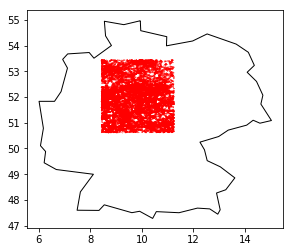

In [109]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.name == 'Germany'].plot(color='white', edgecolor='black')

data_links.plot(ax=ax, color='red')

plt.show()

## 3. Nearest Points

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from shapely.ops import nearest_points
from shapely import wkt
from shapely.geometry import LineString, Point

import math
import utm
import time
import geopandas

In [2]:
data_links = pd.read_csv("./data/LinkDataCleaned.csv")
data_links['shape'] = data_links['shape'].apply(wkt.loads)
data_links = geopandas.GeoDataFrame(data_links, geometry='shape')
data_probes = pd.read_csv("./data/ProbePointsCleaned.csv")
data_probes['shape'] = data_probes['shape'].apply(wkt.loads)
data_probes = geopandas.GeoDataFrame(data_probes, geometry='shape')

In [3]:
data_links.head()

,linkID,linkPVID,refNodeID,nrefNodeID,length,functionalClass,directionOfTravel,speedCategory,fromRefSpeedLimit,toRefSpeedLimit,fromRefNumLanes,toRefNumLanes,multiDigitized,urban,slopeInfo,shape,utms
0,0,62007637,162844982,162809070,335.04,5,B,7,30,30,0,0,F,T,NaN,"LINESTRING (9.3862299 51.49658, 9.3848799 51.4...","[(526811.2368511846, 5705119.536822909), (5267..."
1,1,567329767,162844982,162981512,134.56,5,B,7,0,0,0,0,F,T,NaN,"LINESTRING (9.3862299 51.49658, 9.386710000000...","[(526811.2368511846, 5705119.536822909), (5268..."
2,2,62007648,162877732,162844982,97.01,5,B,7,30,30,0,0,F,T,NaN,"LINESTRING (9.38491 51.4962899, 9.3862299 51.4...","[(526719.7821989493, 5705086.791491644), (5268..."
3,3,78670326,162877732,163152693,314.84,5,B,7,30,30,0,0,F,T,NaN,"LINESTRING (9.38491 51.4962899, 9.3836099 51.499)","[(526719.7821989493, 5705086.791491644), (5266..."
4,4,51881672,174713859,174587951,110.17,3,B,6,50,50,2,2,F,T,0.00/-0.090|110.17/0.062,"LINESTRING (8.79034 53.0643099, 8.79147 53.065...","[(485950.56389726826, 5879445.059722516), (486..."


In [4]:
data_probes.head()

,probeID,sampleID,latitude,longitude,altitude,speed,heading,shape,easting,northing,zoneNumber,zoneLetter
0,0,3496,51.496868,9.386022,200,23,339,POINT (9.38602223061025 51.496868217364),526796.651941,5.705152e+06,32,U
1,1,3496,51.496682,9.386157,200,10,129,POINT (9.38615726307034 51.49668222293261),526806.134609,5.705131e+06,32,U
2,2,3496,51.496705,9.386422,201,21,60,POINT (9.386422298848631 51.4967048540711),526824.519427,5.705133e+06,32,U
3,3,3496,51.496749,9.386840,201,0,360,POINT (9.38683996908367 51.4967492781579),526853.486901,5.705139e+06,32,U
4,4,3496,51.496864,9.387294,199,0,360,POINT (9.387294016778471 51.4968639425933),526884.938219,5.705152e+06,32,U


In [5]:
x1 = utm.from_latlon(43.374880, -78.119956)[0]
y1 = utm.from_latlon(43.374880, -78.119956)[1]
x2 = utm.from_latlon(43.374880, -78.119666)[0]
y2 = utm.from_latlon(43.374880, -78.119666)[1]

p1 = Point(x1,y1)
p2 = Point(x2,y2)
p1.distance(p2)

23.508953320446775

In [6]:
def convert_line_to_utm(line):
    lat_long = line.coords
    utm_coords = []
    for c in lat_long:
        u = utm.from_latlon(c[1],c[0])
        utm_coords.append((u[0],u[1]))
    return utm_coords

In [7]:
from shapely.geometry import LineString

u1 = convert_line_to_utm(data_links.loc[8,"shape"])
x1 = utm.from_latlon(53.069347, 8.796253)[0]
y1 = utm.from_latlon(53.069347, 8.796253)[1]
p1 = Point(x1,y1)
l2 = LineString(u1)

l2.distance(p1)

98.28557448978027

In [ ]:
def calculate_fast_match(number_of_points):
    # Initialize the spatial index and the progress counter
    spatial_index = data_links.sindex
    progress = 0

    for p in data_probes[:number_of_points]['probeID']:
        # Get the current probe and get its UTM point
        probe = data_probes.loc[p]
        probe_point = Point(probe["easting"],probe["northing"])
        
        # Find the 3 closest points with the spatial index and try to find out which is actually the closest
        possible_matches_index = list(spatial_index.nearest((probe["shape"].x, probe["shape"].y), 3))
        best_match = None
        best_distance = 10000000
        
        for l in possible_matches_index:
            # Get the current link and find the UTM line or the nearest point    
            link = data_links.loc[l]
            utms = link["utms"][2:-2].replace("), (", "|").replace(", ", " ").replace("|",", ")
            line = wkt.loads("LINESTRING (" + utms + ")")
            nearest = nearest_points(line, probe_point)[0]
            distance = nearest.distance(probe_point)
            
            # If the current link is closer to the probe we consider it as the best match
            if distance < best_distance:
                best_distance = distance
                best_match = link
        
        # Update the data in the probe file with the matched link and the distance
        data_probes.loc[p,"distance"] = best_distance
        data_probes.loc[p,"linkPVID"] = best_match["linkPVID"]
        
        # Update the progress of the fast match so far
        progress +=1
        if progress % 500 == 0:
            print(progress)
    
    # Save the results of the fast match in a new csv file
    pd.DataFrame(data_probes[:number_of_points]).to_csv("./data/FastMatchedProbes.csv")

In [14]:
spatial_index = data_links.sindex

counter = 0

for p in data_probes[:100000]['probeID']:
    counter +=1
    probe = data_probes.loc[p]
    possible_matches_index = list(spatial_index.nearest((probe["shape"].x, probe["shape"].y), 1))
    link = data_links.loc[possible_matches_index[0]]
    data_probes.loc[p,"linkPVID"] = link["linkPVID"]
    probe_point = Point(probe["easting"],probe["northing"])
    
    utm_from = utm.from_latlon(link["shape"].coords[0][1], link["shape"].coords[0][0])
    from_node = Point(utm_from[0],utm_from[1])
    from_distance = from_node.distance(probe_point)
    to_distance = to_node.distance(probe_point)
    utms = link["utms"][2:-2].replace("), (", "|").replace(", ", " ").replace("|",", ")
    line = wkt.loads("LINESTRING (" + utms + ")")
    nearest = nearest_points(line, probe_point)[0]
    ref_node = Point(line.coords[0][0],line.coords[0][1])
    data_probes.loc[p,"distFromLink"] = nearest.distance(probe_point)
    data_probes.loc[p,"distFromRef"] = ref_node.distance(probe_point)
    radians = math.atan2(ref_node.y-probe_point.y, ref_node.x-probe_point.x)
    ref_node_direction= int(math.degrees(radians))
    if ref_node_direction <= 0:
        ref_node_direction = ref_node_direction+360
    if abs(ref_node_direction-probe["heading"])<= 90:
        data_probes.loc[p,"direction"] = 'T'
    else:
        data_probes.loc[p,"direction"] = 'F'
    if counter % 500 == 0:
        print(counter)
pd.DataFrame(data_probes[:100000]).to_csv("./data/matched_probes_0-100000.csv")

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
85000


## Final Script

In [2]:
# Standard python package for data manipulation
import pandas as pd
import numpy as np

# Python packages for handling geo objects and calculating distances
from shapely import wkt
from shapely.ops import nearest_points
from shapely.geometry import LineString, Point

# Gepandas for storing geo data in a pandas dataframe
import geopandas

# Helps to convert lat long to UTM coordinates
import math
import utm

In [ ]:
def load_and_clean_probes():
    # Load the column names for the probe dataframe
    names = ["sampleID", "dateTime", "sourceCode", "latitude", "longitude", "altitude", "speed", "heading"]
    
    # Read the csv file to a standard pandas dataframe and convert indexes and the shape to UTM
    data_probes = pd.read_csv("./data/ProbePoints.csv", header=None, names=names)
    data_probes.index.name = 'probeID'
    data_probes = data_probes.drop(["sourceCode"],axis=1)
    data_probes = data_probes.drop(["dateTime"],axis=1)
    data_probes["shape"] = data_probes.apply(lambda row: "POINT ( " + str(row["longitude"]) + " " + str(row["latitude"]) + ")", axis=1)
    data_probes["easting"] = data_probes.apply(lambda row: utm.from_latlon(row["latitude"],row["longitude"])[0], axis=1)
    data_probes["northing"] = data_probes.apply(lambda row: utm.from_latlon(row["latitude"],row["longitude"])[1], axis=1)
    data_probes["zoneNumber"] = 32
    data_probes["zoneLetter"] = "U"
    data_probes['shape'] = data_probes['shape'].apply(wkt.loads)
    
    # Create a geopandas dataframe and finally save the dataframe on disk
    data_probes = geopandas.GeoDataFrame(data_probes, geometry='shape')
    data_probes.to_csv("./data/ProbePointsCleaned.csv")
    
    # Return the cleaned dataframe for further usage
    return data_probes

In [ ]:
def calculate_wkt(value):
    # Takes in the shape info of a link and converts it to a wkt LINESTRING
    wkt = "LINESTRING ("
    coords = str(value).split("|")
    
    # Loop over all coordinates and add the text to the wkt format
    for c in coords:
        splitted = c.split("/")
        wkt = wkt + splitted[1] + " " + splitted[0] + ", "
        
    # Cut off the last comma
    wkt = wkt[:-2] + ")"
    
    # Return the well known text for the polyline
    return wkt

def convert_line_to_utm(line):
    # Converts a wkt linestring to a list of utm coordinates
    lat_long = line.coords
    utm_coords = []
    
    # Loop over all lat_long pairs within the linestring
    for c in lat_long:
        u = utm.from_latlon(c[1],c[0])
        utm_coords.append((u[0],u[1]))
        
    # Return the utm array
    return utm_coords

In [ ]:
def load_and_clean_links():
    # Load the column names for the link dataframe
    names = ["linkPVID","refNodeID","nrefNodeID","length","functionalClass","directionOfTravel","speedCategory","fromRefSpeedLimit","toRefSpeedLimit","fromRefNumLanes","toRefNumLanes","multiDigitized","urban","timeZone","shapeInfo","curvatureInfo","slopeInfo"]
    
    # Read the csv file to a standard pandas dataframe and convert indexes and the shape to UTM
    data_links = pd.read_csv("./data/LinkData.csv", header=None, names=names)
    data_links.index.name = 'linkID'
    data_links['shape'] = data_links["shapeInfo"].apply(calculate_wkt)
    data_links = data_links.drop(["shapeInfo","curvatureInfo", "timeZone"],axis=1)
    data_links['shape'] = data_links['shape'].apply(wkt.loads)
    
    # Create a geopandas dataframe and finally save the dataframe on disk
    data_links = geopandas.GeoDataFrame(data_links, geometry='shape')
    data_links["utms"] = data_links["shape"].apply(convert_line_to_utm)
    data_links.to_csv("./data/LinkDataCleaned.csv")
    
    # Return the cleaned dataframe for further usage
    return data_links

In [ ]:
def load_cleaned_data():
    # Load the cleaned link data and convert it to a geopandas dataframe
    data_links = pd.read_csv("./data/LinkDataCleaned.csv")
    data_links['shape'] = data_links['shape'].apply(wkt.loads)
    data_links = geopandas.GeoDataFrame(data_links, geometry='shape')
    
    # Load the cleaned link data and convert it to a geopandas dataframe
    data_probes = pd.read_csv("./data/ProbePointsCleaned.csv")
    data_probes['shape'] = data_probes['shape'].apply(wkt.loads)
    data_probes = geopandas.GeoDataFrame(data_probes, geometry='shape')
    
    # Return both dataframes for further usage
    return data_links, data_probes

In [15]:
def calculate_fast_match(data_links, data_probes, number_of_points):
    # Initialize the spatial index and the progress counter
    spatial_index = data_links.sindex
    progress = 0

    for p in data_probes[:number_of_points]['probeID']:
        # Get the current probe and get its UTM point
        probe = data_probes.loc[p]
        probe_point = Point(probe["easting"],probe["northing"])
        
        # Find the 3 closest points with the spatial index and try to find out which is actually the closest
        possible_matches_index = list(spatial_index.nearest((probe["shape"].x, probe["shape"].y), 3))
        best_match = None
        best_distance = 10000000
        
        for l in possible_matches_index:
            # Get the current link and find the UTM line or the nearest point    
            link = data_links.loc[l]
            # (123),(456)->123|456
            utms = link["utms"][2:-2].replace("), (", "|").replace(", ", " ").replace("|",", ")
            line = wkt.loads("LINESTRING (" + utms + ")")
            nearest = nearest_points(line, probe_point)[0]
            distance = nearest.distance(probe_point)
            
            # If the current link is closer to the probe we consider it as the best match
            if distance < best_distance:
                best_distance = distance
                best_match = link
        
        # Update the data in the probe file with the matched link and the distance
        data_probes.loc[p,"distance"] = best_distance
        data_probes.loc[p,"linkPVID"] = best_match["linkPVID"]
        
        # Update the progress of the fast match so far
        progress +=1
        if progress % 500 == 0:
            print(progress)
    
    # Save the results of the fast match in a new csv file
    pd.DataFrame(data_probes[:number_of_points]).to_csv("./data/FastMatchedProbes.csv")

In [17]:
def calculate_accurate_match(data_links, data_probes, number_of_points):
    # Initialize the spatial index and the progress counter
    spatial_index = data_links.sindex
    progress = 0

    for p in data_probes[:number_of_points]['probeID']:
        # Get the current probe and get its UTM point
        probe = data_probes.loc[p]
        probe_point = Point(probe["easting"],probe["northing"])
        
        # Find the closest point with the spatial index 
        possible_matches_index = list(spatial_index.nearest((probe["shape"].x, probe["shape"].y), 1))

        # Get the current link and find the UTM line or the nearest point  
        link = data_links.loc[possible_matches_index[0]]
        utms = link["utms"][2:-2].replace("), (", "|").replace(", ", " ").replace("|",", ")
        line = wkt.loads("LINESTRING (" + utms + ")")
        nearest = nearest_points(line, probe_point)[0]
        link_distance = nearest.distance(probe_point)
        ref_node = Point(line.coords[0][0],line.coords[0][1])
        ref_distance = ref_node.distance(probe_point)
        
        # Update dataframe attributes
        data_probes.loc[p,"linkPVID"] = link["linkPVID"]
        data_probes.loc[p,"distFromLink"] = link_distance
        data_probes.loc[p,"distFromRef"] = ref_distance
        
        # Calculate the orientation relative to the ref node
        radians = math.atan2(ref_node.y-probe_point.y, ref_node.x-probe_point.x)
        ref_node_direction= int(math.degrees(radians))
        if ref_node_direction <= 0:
            ref_node_direction = ref_node_direction+360
        if abs(ref_node_direction-probe["heading"])<= 90:
            data_probes.loc[p,"direction"] = 'T'
        else:
            data_probes.loc[p,"direction"] = 'F'
        
        # Update the progress of the fast match so far
        progress +=1
        if progress % 100 == 0:
            print(progress)
    
    # Save the results of the fast match in a new csv file
    pd.DataFrame(data_probes[:number_of_points]).to_csv("./data/AccurateMatchedProbes.csv")

In [9]:
data_p = data_probes[data_probes["sampleID"]==3496]
print("Number of probes in sample 5840304:",len(data_p))
print("Longitude of first probe:", data_p.loc[0,"shape"].x)
print("Latitude of first probe:", data_p.loc[0,"shape"].y)

def calculate_hmm():
    spatial_index = data_links.sindex
    beta = 30
    sigma = 50
    hmm = []
    emissions = []
    projections = []
    transitions = []
    distances = []
    previous_probe = None

    for i in data_p["probeID"]:
        probe = data_p.loc[i]
        possible_matches_index = list(spatial_index.nearest((probe["shape"].x, probe["shape"].y), 3))
        possible_matches = data_links.iloc[possible_matches_index]
        hmm.append(possible_matches_index)
        layer_emmissions = []
        layer_projections = []
        layer_transitions = []
        layer_distances = []
        point = Point(probe["easting"], probe["northing"])
        for p in possible_matches_index:
            link = data_links.loc[p]
            utms = link["utms"][2:-2].replace("), (", "|").replace(", ", " ").replace("|",", ")
            line = wkt.loads("LINESTRING (" + utms + ")")
            nearest = nearest_points(line, point)[0]
            distance = line.distance(point)
            probability = 1/(math.sqrt(math.pi * 2)*sigma) * math.exp(-0.5*(distance/sigma)**2)
            layer_emmissions.append(math.log(probability,2))
            layer_projections.append(nearest)
            layer_distances.append(distance)
            if not pd.Series(previous_probe).empty:
                prev_probe_point = Point(previous_probe["easting"], previous_probe["northing"])
                distance_probes = prev_probe_point.distance(point)
                node_transitions = []
                for projection in projections[-1]:
#                     We could not calculate the right distance on the route in our case we used nearest.distance(projection)
                    d_t = abs(distance_probes - nearest.distance(projection))
                    transition_prob = 1/ beta * math.exp(-d_t/beta)
                    node_transitions.append(math.log(transition_prob,2))
                layer_transitions.append(node_transitions)
        if layer_transitions:
            transitions.append(layer_transitions)
        emissions.append(layer_emmissions)
        projections.append(layer_projections)
        layer_distances.sort()
        distances.append(layer_distances)
        previous_probe = probe

    hmm = np.array(hmm)
    emissions = np.array(emissions)
    transitions = np.array(transitions)
    return hmm, emissions, projections, transitions, distances

def find_path(emissions, transitions, hmm, layer, prev_probabilities):
    if layer >= emissions.shape[0]:
        ind = np.unravel_index(np.argmax(prev_probabilities, axis=None), prev_probabilities.shape)
        return [], ind
    future_probs = []
    for e in range(len(emissions[layer])):
        probability = emissions[layer][e]
        if layer == 0:
            maximize_probs = prev_probabilities
        else:
            maximize_probs = prev_probabilities + transitions[layer-1][e]
        future_probs.append(probability + np.amax(maximize_probs))
    print(future_probs)
    future_probs = np.array(future_probs)
    path , ind = find_path(emissions,transitions,hmm,layer+1,future_probs)
    path.append(hmm[layer][ind])
    ind = np.unravel_index(np.argmax(prev_probabilities, axis=None), prev_probabilities.shape)
    print(ind)
    return path, ind

import time
start = time.time()
hmm, emissions, projections, transitions, distances = calculate_hmm()
end = time.time()
print(end - start)

path, ind = find_path(emissions, transitions, hmm, 0, np.zeros((3,1)))

Number of probes in sample 5840304: 189
Longitude of first probe: 9.38602223061025
Latitude of first probe: 51.496868217364
12.287011861801147
[-6.976441393472391, -7.326028968584239, -7.323514735971729]
[-18.86468903800436, -19.47934155883753, -19.482310047240325]
[-30.857753498502536, -31.58330328453758, -31.148566130278446]
[-42.774490709100945, -43.89153960639464, -43.93549609768437]
[-54.71102126711872, -57.08687033358922, -57.08924620048152]
[-66.61443227811031, -97.68696667253573, -72.5215061599465]
[-78.49282250969708, -110.66879254822138, -87.3735846450758]
[-90.39497174593399, -122.65088512350371, -99.8342413581651]
[-102.28566225730059, -134.44663563162447, -111.81127110256428]
[-114.18402977082715, -146.13137843030904, -123.7921270280974]
[-126.07553031333018, -157.96210423942367, -135.82783603004586]
[-137.9662335984861, -169.8206069301209, -147.78205131387875]
[-149.84964499419647, -181.70051002826153, -159.6929029194605]
[-161.73289926331648, -193.54961436336498, -171.58

In [10]:
hmm

array([[     0,      1,      2],
       [     0,      1,      2],
       [     1,      0,      2],
       [     1,      0,      2],
       [     1,      0,      2],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [     1, 103463,      0],
       [  

In [11]:
emissions

array([[ -6.97644139,  -7.32602897,  -7.32351474],
       [ -6.97039809,  -7.01423298,  -7.01395567],
       [ -6.99014758,  -7.0501593 ,  -7.07670766],
       [ -6.97385246,  -7.57820837,  -7.58937131],
       [ -6.9845758 ,  -8.80497732,  -8.83179467],
       [ -6.97023936, -26.84851899, -10.45706091],
       [ -6.97069022, -26.8906414 , -10.85060722],
       [ -6.96993123, -26.75614025, -10.89037779],
       [ -6.96964434, -26.64888135, -10.94192056],
       [ -6.96976572, -26.47536061, -11.03200725],
       [ -6.97017701, -26.37387955, -11.07813305],
       [ -6.97051753, -26.31807052, -11.08949648],
       [ -6.9706744 , -26.29603829, -11.09293626],
       [ -6.97090762, -26.26575244, -11.10313942],
       [ -6.97100162, -26.25439584, -11.10591694],
       [ -6.97128506, -26.22212179, -11.11672855],
       [ -6.97145737, -26.20369394, -11.12513085],
       [ -6.97178291, -26.17163485, -11.13155236],
       [ -6.971946  , -26.15634328, -11.13686988],
       [ -6.97212037, -26.14084

In [12]:
transitions

array([[[ -4.91784956,  -5.40627653,  -5.38199143],
        [ -5.48866719,  -5.99901208,  -5.85705609],
        [ -5.49191298,  -5.95186799,  -5.90420018]],

       [[ -5.00291688,  -4.96697244,  -4.9198321 ],
        [ -5.66845494,  -5.33861949,  -5.33365208],
        [ -5.20716944,  -5.79990499,  -5.7527609 ]],

       [[ -4.94288475,  -5.72773739,  -5.70365865],
        [ -5.45557774,  -6.15913475,  -6.02218743],
        [ -5.48837129,  -5.86001834,  -6.32130384]],

       ...,

       [[ -4.90886851,  -9.52905284, -11.93212766],
        [ -9.52974796,  -4.908728  , -13.94669009],
        [-11.83461583, -13.88892986,  -4.97207004]],

       [[ -4.90835984,  -9.49043149, -12.02917404],
        [ -9.49140263,  -4.90850885, -14.03170406],
        [-11.89323278, -13.92677136,  -5.04394013]],

       [[ -4.91703221,  -9.61501946, -12.15799012],
        [ -9.61503521,  -4.91712014, -14.1609538 ],
        [-12.66175469, -13.72207159, -19.90622275]]])

In [3]:
data = pd.read_csv("./data/FastMatchedProbes.csv")
# data.columns.values
data = data.drop(["Unnamed: 0", "easting", "northing"],axis=1)
data.index.name = "probeID"

In [4]:
data.mean()

probeID       4.999500e+03
sampleID      1.213334e+04
latitude      5.217841e+01
longitude     9.786671e+00
altitude      1.569434e+02
speed         6.253260e+01
heading       1.636689e+02
zoneNumber    3.200000e+01
distance      7.240690e+00
linkPVID      4.349795e+08
dtype: float64

In [5]:
data


,probeID,sampleID,latitude,longitude,altitude,speed,heading,shape,zoneNumber,zoneLetter,distance,linkPVID
probeID,,,,,,,,,,,,
0,0,3496,51.496868,9.386022,200,23,339,POINT (9.38602223061025 51.496868217364),32,U,4.867825,62007637.0
1,1,3496,51.496682,9.386157,200,10,129,POINT (9.38615726307034 51.49668222293261),32,U,1.658677,62007637.0
2,2,3496,51.496705,9.386422,201,21,60,POINT (9.386422298848631 51.4967048540711),32,U,8.437875,567329767.0
3,3,3496,51.496749,9.386840,201,0,360,POINT (9.38683996908367 51.4967492781579),32,U,3.837079,567329767.0
4,4,3496,51.496864,9.387294,199,0,360,POINT (9.387294016778471 51.4968639425933),32,U,7.203292,567329767.0
5,5,3496,51.496930,9.387716,198,5,89,POINT (9.387715961784119 51.4969302434474),32,U,1.483609,567329767.0
6,6,3496,51.496957,9.387794,198,1,288,POINT (9.38779382966459 51.4969574846327),32,U,1.940018,567329767.0
7,7,3496,51.496952,9.387805,197,0,310,POINT (9.387805229052899 51.4969521202147),32,U,1.064518,567329767.0
8,8,3496,51.496949,9.387818,196,0,274,POINT (9.387818137183789 51.49694901891051),32,U,0.372705,567329767.0


## Calculate slope

In [20]:
data_links = pd.read_csv("./data/LinkDataCleaned.csv")
data_links['shape'] = data_links['shape'].apply(wkt.loads)
data_links = geopandas.GeoDataFrame(data_links, geometry='shape')
data_links.head()

,linkID,linkPVID,refNodeID,nrefNodeID,length,functionalClass,directionOfTravel,speedCategory,fromRefSpeedLimit,toRefSpeedLimit,fromRefNumLanes,toRefNumLanes,multiDigitized,urban,slopeInfo,shape,utms
0,0,62007637,162844982,162809070,335.04,5,B,7,30,30,0,0,F,T,NaN,"LINESTRING (9.3862299 51.49658, 9.3848799 51.4...","[(526811.2368511846, 5705119.536822909), (5267..."
1,1,567329767,162844982,162981512,134.56,5,B,7,0,0,0,0,F,T,NaN,"LINESTRING (9.3862299 51.49658, 9.386710000000...","[(526811.2368511846, 5705119.536822909), (5268..."
2,2,62007648,162877732,162844982,97.01,5,B,7,30,30,0,0,F,T,NaN,"LINESTRING (9.38491 51.4962899, 9.3862299 51.4...","[(526719.7821989493, 5705086.791491644), (5268..."
3,3,78670326,162877732,163152693,314.84,5,B,7,30,30,0,0,F,T,NaN,"LINESTRING (9.38491 51.4962899, 9.3836099 51.499)","[(526719.7821989493, 5705086.791491644), (5266..."
4,4,51881672,174713859,174587951,110.17,3,B,6,50,50,2,2,F,T,0.00/-0.090|110.17/0.062,"LINESTRING (8.79034 53.0643099, 8.79147 53.065...","[(485950.56389726826, 5879445.059722516), (486..."


In [85]:
data_probes = pd.read_csv("./data/FastMatchedProbes.csv")
data_probes = data_probes.drop(["probeID","Unnamed: 0"],axis=1)
data_probes.head()
data_probes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
sampleID      1000 non-null int64
latitude      1000 non-null float64
longitude     1000 non-null float64
altitude      1000 non-null int64
speed         1000 non-null int64
heading       1000 non-null int64
shape         1000 non-null object
easting       1000 non-null float64
northing      1000 non-null float64
zoneNumber    1000 non-null int64
zoneLetter    1000 non-null object
linkPVID      1000 non-null float64
distance      1000 non-null float64
dtypes: float64(6), int64(5), object(2)
memory usage: 101.6+ KB


In [101]:
def calculate_slope_for_file(data_links, csv_file="./data/FastMatchedProbes.csv", ):
    # Load the probes
    data_probes = pd.read_csv(csv_file)
    print(len(data_probes))
    data_probes = data_probes.drop(["probeID", "Unnamed: 0"], axis=1)

    # Find all the unique samples within the matched probes
    samples = data_probes["sampleID"].unique()

    for s in samples:
        # Find all probes that belong to sample s
        probes_for_sample = data_probes[data_probes["sampleID"] == s]
        previous_probe = None
        previous_index = None
        first = True

        # Iterate over all probes wih the same sampleID
        current_probe = probes_for_sample.iloc[0]
        for index, row in probes_for_sample.iterrows():
            if not first:
                # Take the current and the previous point
                current_probe = probes_for_sample.loc[index]
                previous_probe_point = Point(previous_probe["easting"], previous_probe["northing"])
                current_probe_point = Point(current_probe["easting"], current_probe["northing"])

                # Calculate the distance and the difference in altitude bettween the points
                distance = previous_probe_point.distance(current_probe_point)
                alt_dif = float(current_probe["altitude"]) - float(previous_probe["altitude"])

                # Check if there is a slope
                if distance > 0:
                    slope = math.atan(alt_dif / distance)
                else:
                    slope = 0

                # Save the data back to the dataframe for further evaluation
                data_probes.loc[index, "slopeBefore"] = slope
                data_probes.loc[previous_index, "slopeAfter"] = slope
                link = data_links[data_links["linkPVID"] == current_probe["linkPVID"]]
                data_probes.loc[index, "surveyedSlope"] = link["slopeInfo"].iloc[0]

            # Go on to the next probe
            previous_probe = current_probe
            previous_index = index
            first = False

    return data_probes      

In [102]:
sloped = calculate_slope_for_file(data_links)
sloped = sloped.drop(["shape","easting","northing", "longitude", "latitude", "zoneNumber", "zoneLetter"], axis =1)
sloped

10000


,sampleID,altitude,speed,heading,distance,linkPVID,slopeBefore,slopeAfter,surveyedSlope
0,3496,200,23,339,4.867825,62007637.0,NaN,0.000000,NaN
1,3496,200,10,129,1.658677,62007637.0,0.000000,0.053799,NaN
2,3496,201,21,60,8.437875,567329767.0,0.053799,0.000000,NaN
3,3496,201,0,360,3.837079,567329767.0,0.000000,-0.058754,NaN
4,3496,199,0,360,7.203292,567329767.0,-0.058754,-0.033096,NaN
5,3496,198,5,89,1.483609,567329767.0,-0.033096,0.000000,NaN
6,3496,198,1,288,1.940018,567329767.0,0.000000,-0.789908,NaN
7,3496,197,0,310,1.064518,567329767.0,-0.789908,-0.805728,NaN
8,3496,196,0,274,0.372705,567329767.0,-0.805728,0.000000,NaN
9,3496,196,0,226,0.748059,567329767.0,0.000000,0.850482,NaN


In [103]:
sloped.to_csv("./data/SlopeProbes.csv", index=False)